# Spam Classification using CNN

In this notebook, I want to classify the comments into 2 categories. The goal is to identify whether a headline is belong to 1 of 2 classes:
- Not-Spam or 0
- Spam or 1

To achieve the goal I will use CNN (Convolutional). A convolutional neural network is a feed-forward neural network that is generally used to analyze visual images by processing data with grid-like topology. It’s also known as a ConvNet. A convolutional neural network is used to detect and classify objects in an image or text.
I will use SpacY to convert a words into a vector. 
Then this work based on the [work](https://arxiv.org/abs/1408.5882) of Yoon Kim published in 2014
*  Each of the word vectors are of k dimension
*  the sentence length is n, (n=length of longest sentence)
*  n x k matrix represents a sentence

*  Filters of size 3xk, 4xk and 5xk are used along with maxpooling to extract features from the sentences. 

![](https://i.imgur.com/oEMRsZY.png)
Then the workflow to classificate our document is:

**Data Import**:

Data is the lifeblood of predictive analysis. We should know which data that we’ll use, where & how to gather them, then how to make it useful to solve our problem.

**Data Cleaning**:

Then we’ll use several mechanism like lowercasing the document, remove short form, and finally remove the punctuation and symbols.

**Data Pre-Processing**:

After that we using spacy to convert our document into a vector.

**Data Modelling**:

Finally we using 1 model to classificate our documents (CNN).

5. **Result Discussion**

Discuss the final result (You will see in the end of the notebook)

**=========================================================================================================================**

**=========================================================================================================================**

## **Data Pre Processing**
*  Cleaning the data
*  Building word vectors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torch.nn.functional as F

In [2]:
comments = pd.read_excel("Comment Spam.xls")

#### Let us check the data

Check the first five of the dataframe and count the numbers of data on the class

In [3]:
comments.head()

,No,Comment,Class
0,1,this song is racist,0
1,2,and how many subscribers compared to her over ...,1
2,3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,4,well done shakira,0
4,5,:D subscribe to me for daily vines,1


In [4]:
comments.Class.value_counts()

1    669
0    631
Name: Class, dtype: int64

#### The comments classification are as follows:
* **Not Spam** (label==0) If the comment is not a spam.
* **Spam** (label==1) If the comment is a spam. 

**Pre-processing the comments**

Remove the symbol, the punctuation, link website, and the numbers, and replace the upper case with lower case

In [5]:
def normalise_text (text):
    text = text.str.lower()
    text = text.str.replace(r"\#","")
    text = text.str.replace(r"http\S+","URL")
    text = text.str.replace(r"@"," ")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [6]:
comments["Comment"]=normalise_text(comments["Comment"])

Let us look at the cleaned text once

In [7]:
comments.head()

,No,Comment,Class
0,1,this song is racist,0
1,2,and how many subscribers compared to her over ...,1
2,3,hi! check out our awesome covers! and say what...,1
3,4,well done shakira,0
4,5,d subscribe to me for daily vines,1


### Embedding using spaCy 

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
#apply the spaCy nlp pipeline
doc = comments["Comment"].apply(nlp) 

#you could extract a lot more information once you pass the data through the nlp pipeline, such as POS tagging, recognising important entities, etc. 

 ### Form 3d numpy array for storing word vectors, to be used for classifying
 
 * Each sentence is a matrix and these would be used as Tensors by the CNN
 
 * The dimensions of each matrix would be: **length of longest sentence** x **length of vector**
 
 * The dimension of the tensor :
     * **number of comments** x **length of longest sentence** x **length of vector**

In [10]:
max_sent_len=max(len(doc[i]) for i in range(0,len(doc)))
print("Length of longest sentence: ", max_sent_len)
#point to be noted this is the number of tokens in the sentence, NOT words

vector_len=len(doc[0][0].vector)
print("Length of each word vector: ", vector_len)

Length of longest sentence:  219
Length of each word vector:  96


In [11]:
#creating the 3D array
comments_matrix=np.zeros((len(doc),max_sent_len,vector_len))

In [12]:
for i in range(0,len(doc)):
    for j in range(0,len(doc[i])):
        comments_matrix[i][j]=doc[i][j].vector

### Create labels

In [13]:
list_labels = np.array(comments["Class"])
print("The number of labels: "+str(list_labels.shape[0]))
print("The number of labels: "+str(comments_matrix.shape[0]))

The number of labels: 1300
The number of labels: 1300


## **CNN in Pytorch**

In [14]:
#if you need to convert numpy ndarray to tensor explicitely
#comments_matrix = torch.from_numpy(comments_matrix)

In [15]:
#for GPU - CUDA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

if device == "cpu":
    print("CUDA IS NOT AVAILABLE")
else:
    print("CUDA IS AVAILABLE")

CUDA IS AVAILABLE


**Train test split**

Split the data into 2 parts test: 25 % and training: 75 %

In [16]:
len_for_split=[int(comments_matrix.shape[0]/4),int(comments_matrix.shape[0]*(3/4))]
print(len_for_split)

[325, 975]


In [17]:
test, train=random_split(comments_matrix,len_for_split)

In [18]:
test.dataset.shape

(1300, 219, 96)

### Declare Hyperparameters

In [19]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.00075
batch_size=100

### Load Data

The dataset is loaded in batches with the Dataset class and Dataloader Module from torch.utils.data

In [20]:
# to transform the data and labels
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [21]:
#load labels #truncating total data to keep batch size 100
labels_train=list_labels[train.indices[0:8100]]
labels_test=list_labels[test.indices[0:2700]]

#load train data
training_data=train.dataset[train.indices[0:8100]].astype(float)
#training_data=training_data.unsqueeze(1)

#load test data
test_data=test.dataset[test.indices[0:2700]].astype(float)
#test_data=test_data.unsqueeze(1)

dataset_train = MyDataset(training_data, labels_train)
dataset_test = MyDataset(test_data, labels_test)


#loading data batchwise
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)


### Setting up the CNN model

In [22]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer13 = nn.Sequential(
            nn.Conv2d(1, 100, kernel_size=(3,vector_len), stride=1,padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(70,1), stride=1))
        self.layer14 = nn.Sequential(
            nn.Conv2d(1, 100, kernel_size=(4,vector_len), stride=1,padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(69,1), stride=1))
        self.layer15 = nn.Sequential(
            nn.Conv2d(1, 100, kernel_size=(5,vector_len), stride=1,padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(68,1), stride=1))
        #self.layer2 = nn.Sequential(
            #nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=0),
            #nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        #concat operation
        self.fc1 = nn.Linear(44400, 30)
        self.fc2 = nn.Linear(30, 2)
        #self.fc3 = nn.Linear(100,3)
        
    def forward(self, x):
        x3 = self.layer13(x)
        x4 = self.layer14(x)
        x5 = self.layer15(x)
        x3 = x3.reshape(x3.size(0), -1)
        x4 = x4.reshape(x4.size(0), -1)
        x5 = x5.reshape(x5.size(0), -1)
        x3 = self.drop_out(x3)
        x4 = self.drop_out(x4)
        x5 = self.drop_out(x5)
        out = torch.cat((x3,x4,x5),1)
        out = self.fc1(out)
        out = self.fc2(out)
        return(out)

In [23]:
#creating instance of our ConvNet class
model = ConvNet()
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#CrossEntropyLoss function combines both a SoftMax activation and a cross entropy loss function in the same function

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the model

In [24]:
# Train the model

loss_list = []
acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    loss_list_element = 0
    acc_list_element = 0
    for i, (data_t, labels) in enumerate(train_loader):
        data_t=data_t.unsqueeze(1)
        data_t, labels = data_t.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(data_t)
        loss = criterion(outputs, labels)
        loss_list_element += loss.item()
        #print("==========forward pass finished==========")
            
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print("==========backward pass finished==========")
        
        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list_element += correct
        
        
    loss_list_element = loss_list_element/np.shape(labels_train)[0]
    acc_list_element = acc_list_element/np.shape(labels_train)[0]
    print('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, loss_list_element,acc_list_element * 100))  
    loss_list.append(loss_list_element)
    acc_list.append(acc_list_element)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for data_t, labels in test_loader:
            data_t=data_t.unsqueeze(1)
            data_t, labels = data_t.to(device), labels.to(device)

            outputs = model(data_t)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc_list.append(correct / total)

    print('Test Accuracy of the model: {} %'.format((correct / total)*100))
    print()

Epoch [1/25], Loss: 0.0394, Training Accuracy: 56.00%
Test Accuracy of the model: 59.07692307692308 %

Epoch [2/25], Loss: 0.0137, Training Accuracy: 62.97%
Test Accuracy of the model: 64.0 %

Epoch [3/25], Loss: 0.0064, Training Accuracy: 75.69%
Test Accuracy of the model: 75.6923076923077 %

Epoch [4/25], Loss: 0.0048, Training Accuracy: 76.92%
Test Accuracy of the model: 84.61538461538461 %

Epoch [5/25], Loss: 0.0037, Training Accuracy: 86.77%
Test Accuracy of the model: 86.46153846153845 %

Epoch [6/25], Loss: 0.0029, Training Accuracy: 88.72%
Test Accuracy of the model: 85.53846153846155 %

Epoch [7/25], Loss: 0.0024, Training Accuracy: 92.21%
Test Accuracy of the model: 87.38461538461539 %

Epoch [8/25], Loss: 0.0020, Training Accuracy: 93.64%
Test Accuracy of the model: 88.3076923076923 %

Epoch [9/25], Loss: 0.0018, Training Accuracy: 93.95%
Test Accuracy of the model: 88.92307692307693 %

Epoch [10/25], Loss: 0.0014, Training Accuracy: 95.18%
Test Accuracy of the model: 89.23

### Evaluating the model

Compute the loss value and the accuracy of the model

In [25]:
## evaluating model

# Test the model
model.eval()
predicted1 = []
test1      = []
with torch.no_grad():
    correct = 0
    total = 0
    for data_t, labels in test_loader:
        data_t=data_t.unsqueeze(1)
        data_t, labels = data_t.to(device), labels.to(device)
        
        outputs = model(data_t)
        _, predicted = torch.max(outputs.data, 1)
        predicted1.append(predicted)
        test1.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {} %'.format((correct / total) * 100))

Test Accuracy of the model: 91.07692307692308 %


### Plot a graph to trace model performance

<function matplotlib.pyplot.show(*args, **kw)>

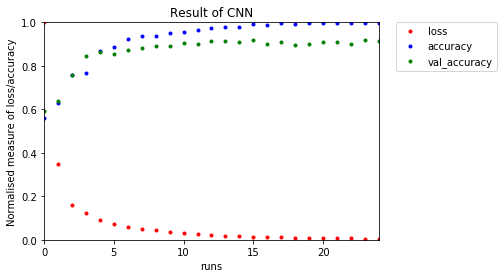

In [26]:
plt.xlabel("runs")
plt.ylabel("Normalised measure of loss/accuracy")
x_len=list(range(len(acc_list)))
plt.axis([0, max(x_len), 0, 1])
plt.title('Result of CNN')
loss=np.asarray(loss_list)/max(loss_list)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc_list, 'b.', label="accuracy")
plt.plot(x_len, val_acc_list, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show

**Result Discussion**

Based on the above plots, CNN has achieved good test accuracy with high consistency. But we should aware about overfitting. There's a lot of causes of the overfitting. But the biggest problem on hyperparameter-tuning (learning rate, epoch, batch_size, and etc). But if we compare the performance with another model like Multinomial Naive Bayes or SVM, the chances of CNN reaching a better result is big but still the problem to get better accuracy is hyperparameter-tuning. In some paper, the researcher successfully proved that CNN is one of the best to classify the text. 

But if we want to get a good result with a faster time then we can use another method like Multinomial Naive Bayes or SVM

**Improving Result**

To achieve the best performances, we may:
Fine Tune Hyper-Parameters : Hyper-parameters are the variables which are set before training and determine the network structure & how the network is trained. (eg : learning rate, batch size, number of epochs). Fine tuning can be done by : Manual Search, Grid Search, Random Search.
Improve Text Pre-Processing : Better pre-processing of input data can be done as per the need of your dataset like removing some special symbols, numbers, stopwords and so on.